In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

category_names.csv
sample_submission.csv
test.bson
train.bson
train_example.bson



The bson files for this competition contain a list of dictionaries, one dictionary per product. Each dictionary contains a product id (key: _id), the category id of the product (key: category_id), and between 1-4 images, stored in a list (key: imgs). Each image list contains a single dictionary per image, which uses the format: {'picture': b'...binary string...'}. 

The bson file can be read and processed iteratively. The following code shows how to read the data from the `train_example.bson` file.

In [2]:
import io
import bson                       # this is installed with the pymongo package
import matplotlib.pyplot as plt
from skimage.data import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data

In [3]:
# Simple data processing

data = bson.decode_file_iter(open('../input/train_example.bson', 'rb'))

prod_to_category = dict()

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data
    prod_to_category[product_id] = category_id
    for e, pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
        # do something with the picture, etc

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

In [4]:
prod_to_category.head()

,category_id
_id,
0,1000010653
1,1000010653
2,1000004079
3,1000004141
4,1000015539


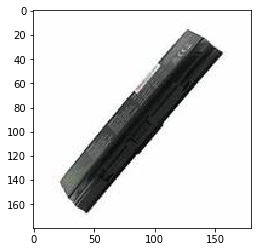

In [5]:
plt.imshow(picture);

For more efficient use of your resources, you can use the `multiprocessing` module to read and process the bson file.

Inspiration for this code is from:  https://stackoverflow.com/questions/43078980/python-multiprocessing-with-generator Note this may be slower on a small file, due to the overhead setting up the workers, but will be significantly faster for the large files.

In [6]:
NCORE =  8

prod_to_category = mp.Manager().dict() # note the difference

def process(q, iolock):
    while True:
        d = q.get()
        if d is None:
            break
        product_id = d['_id']
        category_id = d['category_id']
        prod_to_category[product_id] = category_id
        for e, pic in enumerate(d['imgs']):
            picture = imread(io.BytesIO(pic['picture']))
            # do something with the picture, etc
    
q = mp.Queue(maxsize=NCORE)
iolock = mp.Lock()
pool = mp.Pool(NCORE, initializer=process, initargs=(q, iolock))

# process the file

data = bson.decode_file_iter(open('../input/train_example.bson', 'rb'))
for c, d in enumerate(data):
    q.put(d)  # blocks until q below its max size

# tell workers we're done

for _ in range(NCORE):  
    q.put(None)
pool.close()
pool.join()

# convert back to normal dictionary
prod_to_category = dict(prod_to_category)

prod_to_category = pd.DataFrame.from_dict(prod_to_category, orient='index')
prod_to_category.index.name = '_id'
prod_to_category.rename(columns={0: 'category_id'}, inplace=True)

In [7]:
prod_to_category.head()

,category_id
_id,
0,1000010653
2,1000004079
8,1000010667
9,1000018290
11,1000010653
